<a href="https://www.kaggle.com/code/fall2fire/skin-disease-prediction?scriptVersionId=248847582" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Libaries Required
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import matplotlib.image as mpimg
from zipfile import ZipFile
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , models
from sklearn.utils.class_weight import compute_class_weight
import cv2 
from tensorflow.keras.applications import ResNet152V2
import tensorflow as tf

2025-07-04 17:53:06.363329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751651586.645301      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751651586.714972      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Importing dataset**

In [2]:
import os

data_path = "/kaggle/input/skin-disease-dataset"
print(os.listdir(data_path))


['skin-disease-datasaet']


In [3]:
inner_path = os.path.join(data_path, "skin-disease-datasaet")
print(os.listdir(inner_path))

['test_set', 'train_set']


(224, 224, 3)


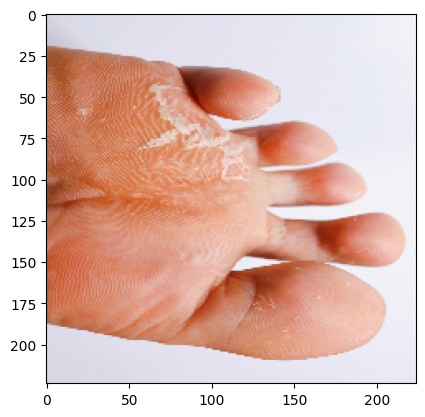

In [4]:
# Providing path to dataset
base_dir ='/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set'
image_path='/kaggle/input/skin-disease-dataset/skin-disease-datasaet/train_set/FU-athlete-foot/FU-athlete-foot (1).png'

# Reading the image
img=mpimg.imread(image_path)
print(img.shape)

#display image
plt.imshow(img)
plt.axis()
plt.show()

**Preprocessing of Image data**

In [5]:
img_size = 224
batch_size = 32

def resize_and_pad(img):
    desired_size = 224
    old_size = img.shape[:2]  # (height, width)

    # Compute ratio and new size
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])

    # Resize the image
    img = cv2.resize(img, (new_size[1], new_size[0]))

    # Padding
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    padded_img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    return padded_img / 255.0  # Normalize [0, 1]

data_gen = ImageDataGenerator(
    preprocessing_function=resize_and_pad,
    rotation_range=25,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.25
)



train_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    interpolation='bilinear',
    shuffle=True
)

valid_gen = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    interpolation='bilinear',
    shuffle=False
)

print("Class indices:", train_gen.class_indices)
print("Class sample counts:", np.bincount(train_gen.classes))


Found 695 images belonging to 8 classes.
Found 229 images belonging to 8 classes.
Class indices: {'BA- cellulitis': 0, 'BA-impetigo': 1, 'FU-athlete-foot': 2, 'FU-nail-fungus': 3, 'FU-ringworm': 4, 'PA-cutaneous-larva-migrans': 5, 'VI-chickenpox': 6, 'VI-shingles': 7}
Class sample counts: [102  60  93  97  68  75 102  98]


Class Weights: {0: 0.8517156862745098, 1: 1.4479166666666667, 2: 0.9341397849462365, 3: 0.895618556701031, 4: 1.2775735294117647, 5: 1.1583333333333334, 6: 0.8517156862745098, 7: 0.8864795918367347}


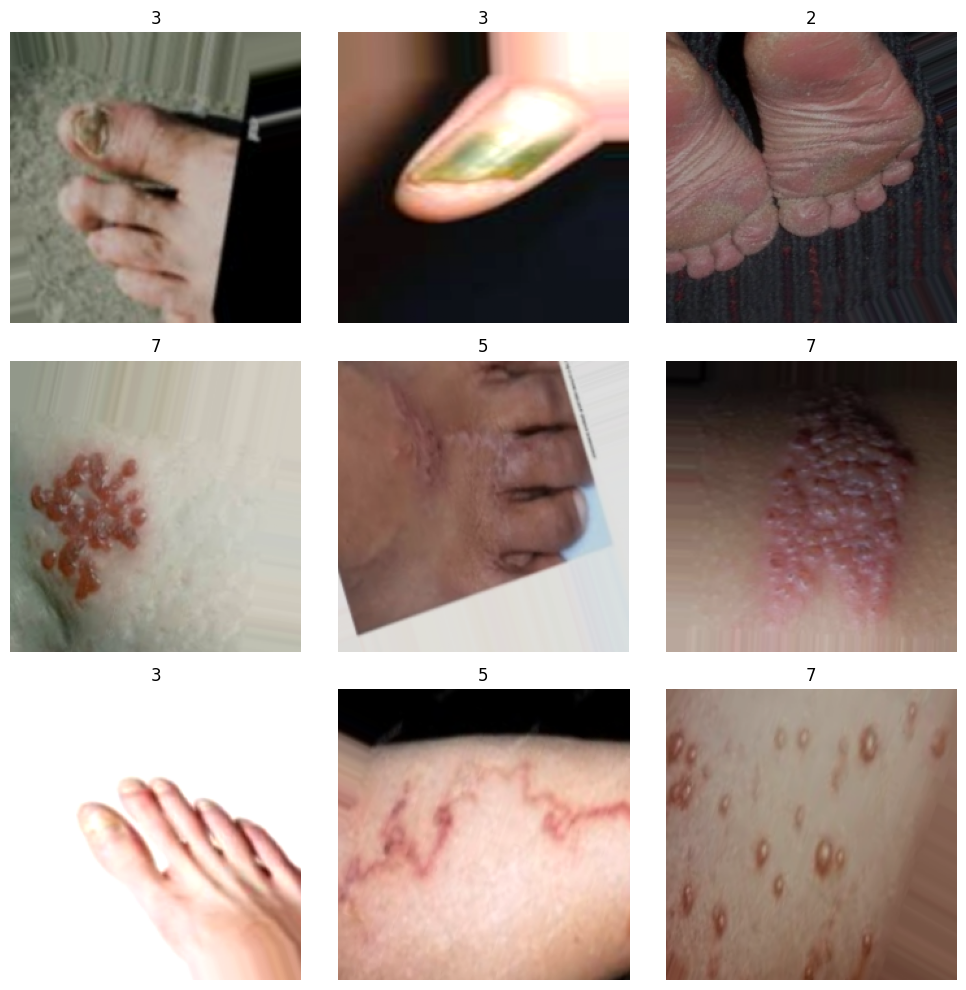

In [6]:
#  Compute Class Weights 
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# Preview Images 
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))
    plt.axis('off')
plt.tight_layout()
plt.show()

In [7]:
#Model Creation
base_model = ResNet152V2(include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1751651603.564186      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751651603.564853      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 7, 7, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,858,248 (224.53 MB)

 Trainable params: 526,600 (2.01 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [8]:
#Training the Model
history=model.fit(
    train_gen,
    epochs=25,
    validation_data=valid_gen,
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1751651635.597973      81 service.cc:148] XLA service 0x7d1e5c0b9cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751651635.598870      81 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751651635.598897      81 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751651639.378874      81 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751651646.690701      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4583 - loss: 1.5099 - val_accuracy: 0.8166 - val_loss: 0.5886
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 575ms/step - accuracy: 0.8010 - loss: 0.5868 - val_accuracy: 0.7729 - val_loss: 0.6005
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 581ms/step - accuracy: 0.8823 - loss: 0.3571 - val_accuracy: 0.8559 - val_loss: 0.4506
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 581ms/step - accuracy: 0.8962 - loss: 0.3004 - val_accuracy: 0.8821 - val_loss: 0.3450
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 591ms/step - accuracy: 0.8996 - loss: 0.2471 - val_accuracy: 0.8559 - val_loss: 0.3957
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 578ms/step - accuracy: 0.9323 - loss: 0.2109 - val_accuracy: 0.8821 - val_loss: 0.3486
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 588ms/step - accuracy: 0.9086 - loss: 0.2369 - val_accuracy: 0.8952 - val_loss: 0.3586
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 591ms/step - accuracy: 0.9481 - loss: 0.1502 - val_accuracy: 0.8865 -

In [9]:
print("Evaluating model........")
val_loss,val_accuracy=model.evaluate(valid_gen,steps=valid_gen.samples//batch_size)
print(f"validation accuracy:{val_accuracy*100:.2f}%")

Evaluating model........
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 473ms/step - accuracy: 0.8869 - loss: 0.3970
validation accuracy:90.18%


Classification Report i.e. **Accuracy,F1-Score,Precision,Recall**

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get true and predicted labels
Y_true = valid_gen.classes
Y_pred = np.argmax(model.predict(valid_gen), axis=1)

# Report
print(classification_report(Y_true, Y_pred, target_names=valid_gen.class_indices.keys()))


8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
                            precision    recall  f1-score   support

            BA- cellulitis       0.88      0.88      0.88        33
               BA-impetigo       1.00      0.90      0.95        20
           FU-athlete-foot       0.75      0.97      0.85        31
            FU-nail-fungus       1.00      0.84      0.92        32
               FU-ringworm       0.96      1.00      0.98        22
PA-cutaneous-larva-migrans       0.80      0.80      0.80        25
             VI-chickenpox       1.00      0.97      0.99        34
               VI-shingles       1.00      0.94      0.97        32

                  accuracy                           0.91       229
                 macro avg       0.92      0.91      0.91       229
              weighted avg       0.92      0.91      0.91       229



Classification Report is quite good as f1 score is above 0.5 and model accuracy is around 92% so considering it we can create a prediction 

In [11]:
model.save('Skin_disease_model.h5')

Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


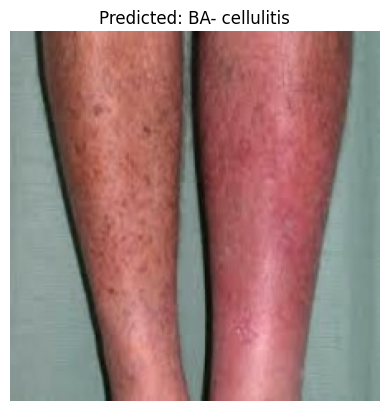

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model("/kaggle/working/Skin_disease_model.h5")

# Class index to label mapping
class_indices = {
    'BA- cellulitis': 0,
    'BA-impetigo': 1,
    'FU-athlete-foot': 2,
    'FU-nail-fungus': 3,
    'FU-ringworm': 4,
    'PA-cutaneous-larva-migrans': 5,
    'VI-chickenpox': 6,
    'VI-shingles': 7
}

# Reverse the mapping to get label from prediction index
index_to_label = {v: k for k, v in class_indices.items()}

img_path = "/kaggle/input/skin-disease-dataset/skin-disease-datasaet/test_set/BA- cellulitis/BA- cellulitis (73).jpg"

# Load and preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Predict
pred = model.predict(img_array)
predicted_index = np.argmax(pred)
predicted_label = index_to_label[predicted_index]

# Show result
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_label}")
plt.show()
